In [3]:
pip install plotly

In [7]:
!pip install tensorflow
!pip install wordcloud

In [9]:
conda install -c conda-forge xgboost

Solving environment: ...working... done

## Package Plan ##

  environment location: D:\Fore\Python

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda





    _py-xgboost-mutex-2.0      |            cpu_0          11 KB  conda-forge
    libxgboost-1.5.0           |       hd77b12b_2         1.3 MB
    py-xgboost-1.5.0           |   py39haa95532_2         156 KB
    xgboost-1.5.0              |   py39haa95532_2          15 KB
    ------------------------------------------------------------
                                           Total:         1.5 MB

The following NEW packages will be INSTALLED:

  _py-xgboost-mutex  conda-forge/win-64::_py-xgboost-mutex-2.0-cpu_0
  libxgboost         pkgs/main/win-64::libxgboost-1.5.0-hd77b12b_2
  py-xgboost         pkgs/main/win-64::py-xgboost-1.5.0-py39haa95532_2
  xgboost            pkgs/main/win-64::xgboost-1.5.0-py39haa95532_2




xgboost-1.5.0        | 15 KB     |            |   0% 
xgboost-1.5.0        | 15 KB     | ########## | 100% 
xgboost-1.5.0        | 15 KB     | ########## | 100% 

py-xgboost-1.5.0     | 156 KB    |            |   0% 
py-xgboost-1.5.0     | 156 KB    | ########## | 100%

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

from sklearn.model_selection import train_test_split

import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential

from keras.layers import Dense,Dropout

In [12]:
#Loading the required data
df=pd.read_csv('C:/Users/abhis/OneDrive/Desktop/movie.csv')
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [14]:
#Looking for null data
df.isnull().sum()

text     0
label    0
dtype: int64

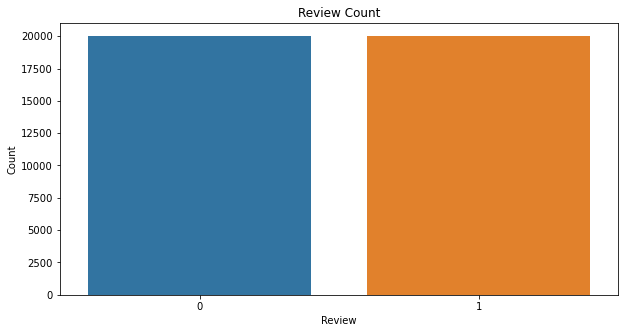

In [15]:
#Generating a countplot for target label
plt.figure(figsize=(10,5))
sns.barplot(x=df['label'].value_counts().index,y=df['label'].value_counts())
plt.title('Review Count')
plt.xlabel('Review')
plt.ylabel('Count');

In [16]:
#Generating the column text_len
df['text_len']=df['text'].apply(lambda x:len(x.split(' ')))
df.head()

,text,label,text_len
0,I grew up (b. 1965) watching and loving the Th...,0,151
1,"When I put this movie in my DVD player, and sa...",0,326
2,Why do people who do not know what a particula...,0,184
3,Even though I have great interest in Biblical ...,0,69
4,Im a die hard Dads Army fan and nothing will e...,1,178


In [17]:
#Generating the column char_len
def char_count(text):
    charc=0
    for char in text.split():
        charc +=len(char)
    return charc

df['char_len']=df['text'].apply(char_count)

In [18]:
df.groupby('label').describe().T

label                      0             1
text_len count  20019.000000  19981.000000
         mean     229.195165    233.466844
         std      164.316689    177.766087
         min        4.000000     12.000000
         25%      128.000000    125.000000
         50%      174.000000    173.000000
         75%      278.500000    285.000000
         max     1522.000000   2470.000000
char_len count  20019.000000  19981.000000
         mean    1064.313602   1095.581552
         std      778.468501    855.119309
         min       27.000000     52.000000
         25%      579.000000    567.000000
         50%      800.000000    800.000000
         75%     1295.000000   1338.000000
         max     7448.000000  11235.000000

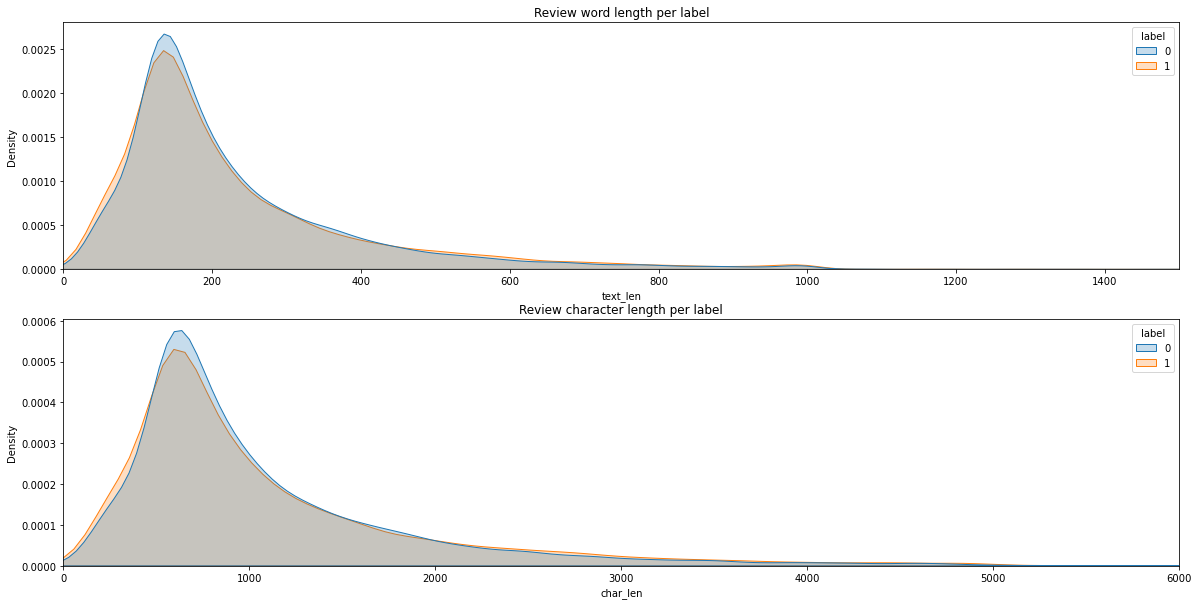

In [19]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
sns.kdeplot(x=df['text_len'],hue=df['label'],shade=True)
plt.title('Review word length per label')
plt.xlim(0,1500)

plt.subplot(2,1,2)
sns.kdeplot(x=df['char_len'],hue=df['label'],shade=True)
plt.title('Review character length per label')
plt.xlim(0,6000)

plt.show()

In [20]:
def clean_text(text):
    text=str(text).lower()
    text=re.sub('\[.*?\]', '', text)
    text=re.sub('https?://\S+|www\.\S+', '', text)
    text=re.sub('<.*?>+', '', text)
    text=re.sub('[%s]' % re.escape(string.punctuation),'',text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [21]:
sws=stopwords.words('english')
lemma=WordNetLemmatizer()

def preprocessdata(text):
    text= ' '.join(word for word in text.split(' ') if word not in sws)
    text= ' '.join(lemma.lemmatize(word) for word in text.split(' '))
    return text

In [22]:
df['clean']=df['text'].apply(clean_text)

In [23]:
nltk.download('omw-1.4')

df['final']=df['clean'].apply(preprocessdata)
df.head()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abhis\AppData\Roaming\nltk_data...


,text,label,text_len,char_len,clean,final
0,I grew up (b. 1965) watching and loving the Th...,0,151,724,i grew up b watching and loving the thunderbi...,grew b watching loving thunderbird mate schoo...
1,"When I put this movie in my DVD player, and sa...",0,326,1486,when i put this movie in my dvd player and sat...,put movie dvd player sat coke chip expectation...
2,Why do people who do not know what a particula...,0,184,800,why do people who do not know what a particula...,people know particular time past like feel nee...
3,Even though I have great interest in Biblical ...,0,69,283,even though i have great interest in biblical ...,even though great interest biblical movie bore...
4,Im a die hard Dads Army fan and nothing will e...,1,178,806,im a die hard dads army fan and nothing will e...,im die hard dad army fan nothing ever change g...


In [24]:
df['final2']=df['final'].apply(lambda x:' '.join(text for text in x.split(' ') if len(text)>2))
df.head()

,text,label,text_len,char_len,clean,final,final2
0,I grew up (b. 1965) watching and loving the Th...,0,151,724,i grew up b watching and loving the thunderbi...,grew b watching loving thunderbird mate schoo...,grew watching loving thunderbird mate school w...
1,"When I put this movie in my DVD player, and sa...",0,326,1486,when i put this movie in my dvd player and sat...,put movie dvd player sat coke chip expectation...,put movie dvd player sat coke chip expectation...
2,Why do people who do not know what a particula...,0,184,800,why do people who do not know what a particula...,people know particular time past like feel nee...,people know particular time past like feel nee...
3,Even though I have great interest in Biblical ...,0,69,283,even though i have great interest in biblical ...,even though great interest biblical movie bore...,even though great interest biblical movie bore...
4,Im a die hard Dads Army fan and nothing will e...,1,178,806,im a die hard dads army fan and nothing will e...,im die hard dad army fan nothing ever change g...,die hard dad army fan nothing ever change got ...


In [25]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [26]:
freqw=df[df['label']==1]['final2'].str.split(expand=True).stack().value_counts()
freqw200=freqw[:200]

fig=px.treemap(freqw200,path=[freqw200.index],values=0)
fig.update_traces(textinfo="label+value")
fig.show()

In [27]:
freqw=df[df['label']==0]['final2'].str.split(expand=True).stack().value_counts()
freqw200=freqw[:200]

fig=px.treemap(freqw200,path=[freqw200.index],values=0)
fig.update_traces(textinfo="label+value")
fig.show()

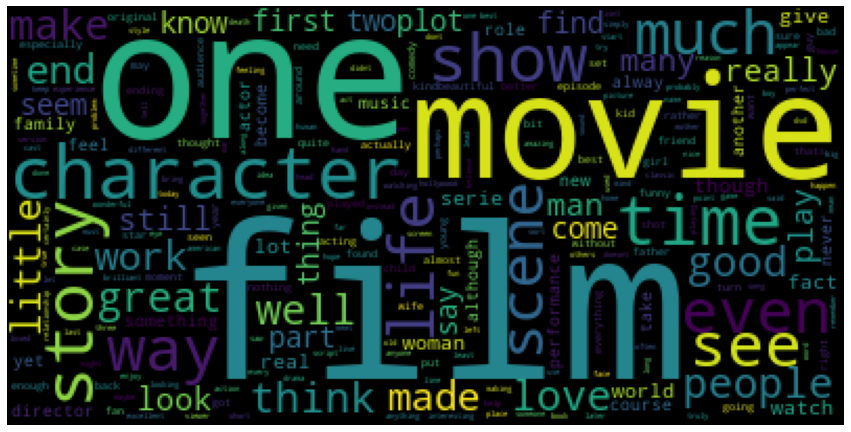

In [28]:
plt.figure(figsize=(15,10))
wc=WordCloud(max_words=500,background_color='black')
wc.generate(' '.join(word for word in df.loc[df['label']==1,'final2']))
plt.imshow(wc)
plt.axis('off')
plt.show()

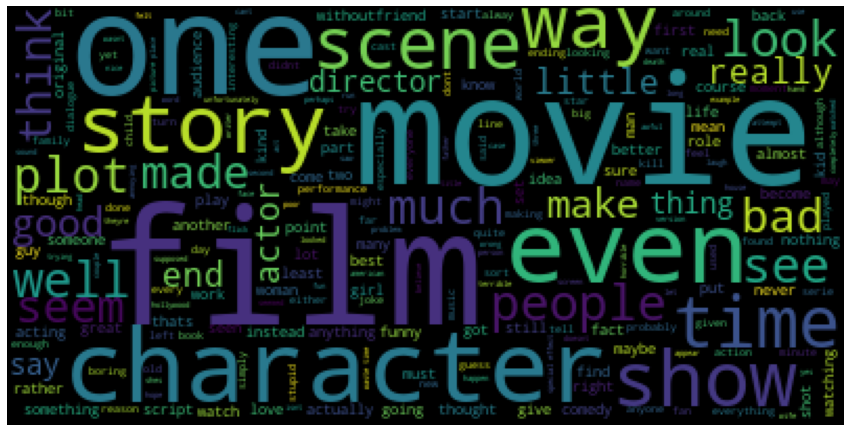

In [29]:
plt.figure(figsize=(15,10))
wc=WordCloud(max_words=500,background_color='black')
wc.generate(' '.join(word for word in df.loc[df['label']==0,'final2']))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [30]:
X=df['final2']
y=df['label']

In [31]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=105)

In [32]:
def test_pipeline(model):
    pipe=Pipeline([('bow',CountVectorizer()),('tfidf',TfidfTransformer()),('model',model)])
    pipe.fit(X_train,y_train)
    y_pred=pipe.predict(X_test)
    print('Accuracy Score: ',accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    plot_confusion_matrix(pipe,X_test,y_test)

Accuracy Score:  0.8597
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      4994
           1       0.88      0.84      0.86      5006

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



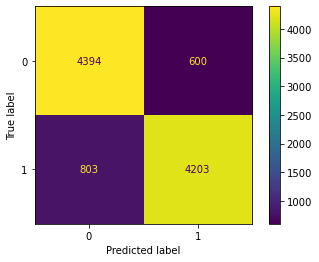

In [33]:
test_pipeline(MultinomialNB())

Accuracy Score:  0.8476
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      4994
           1       0.87      0.81      0.84      5006

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



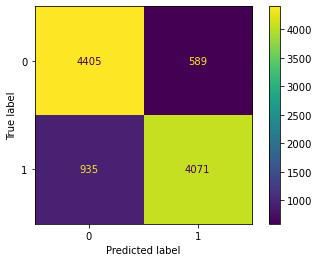

In [34]:
test_pipeline(BernoulliNB())

Accuracy Score:  0.8846
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      4994
           1       0.88      0.89      0.89      5006

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



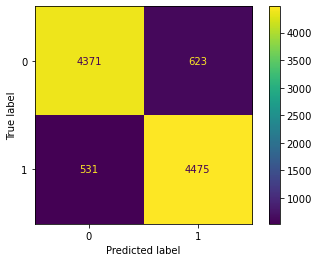

In [35]:
test_pipeline(LogisticRegression())